### Data separation, library import and important functions

In [1]:
### --- importing dependences ---- ###
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import csv
import time
import os
import joblib
import numpy as np
import seaborn as sns
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import *
from rdkit.Chem.rdMolDescriptors import *
from rdkit.Chem.Lipinski import *
from rdkit.Chem.EState import *
from rdkit.Chem.GraphDescriptors import *
from rdkit.Chem.Graphs import *
from math import sqrt, ceil


rad = 2
nbit = 2048
n_est = 1000
sizeleaf = 5
m_fac = 683


In [ ]:
### important functions
def grafic(y_test, y_pred, color):
    plt.plot(y_test, y_test, linestyle='--', color='black', label='y = x')
    plt.scatter(y_test, y_pred, alpha=0.5, color=color, label='Pontos de Teste vs. Previsões')
    plt.title('')
    plt.xlabel('Energia Dados')
    plt.ylabel('Energia RF')
    plt.legend('')
    plt.grid(True)
    plt.show()
    
def flatten_list(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, list):
            flat_list.extend(flatten_list(item))
        else:
            flat_list.append(item)
    return flat_list

def calcular_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calcular_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def avaliar_modelo(y_true, y_pred):
    resultados = {}

    resultados['MAE'] = mean_absolute_error(y_true, y_pred)
    resultados['MSE'] = mean_squared_error(y_true, y_pred)
    resultados['RMSE'] = calcular_rmse(y_true, y_pred)
    resultados['R2'] = r2_score(y_true, y_pred)
    resultados['MAPE'] = calcular_mape(y_true, y_pred)

    return resultados

def properties_array(sSmiles):
    try:
        m = Chem.MolFromSmiles(sSmiles)
        p1 = AllChem.GetMorganFingerprintAsBitVect(m, 2, 512)
        p2 = Chem.rdMolDescriptors.GetMACCSKeysFingerprint(m)

        p3 = [1000*FpDensityMorgan1(m), 1000*FpDensityMorgan2(m), 1000*FpDensityMorgan3(m), ExactMolWt(m), HeavyAtomMolWt(m), 1000*MaxAbsPartialCharge(m), 1000*MaxPartialCharge(m), 1000*MinAbsPartialCharge(m), 1000*MinPartialCharge(m), NumRadicalElectrons(m), NumValenceElectrons(m),1000*CalcFractionCSP3(m),10*CalcKappa1(m),10*CalcKappa2(m),10*CalcKappa3(m),CalcLabuteASA(m),CalcNumAliphaticCarbocycles(m),CalcNumAliphaticHeterocycles(m),CalcNumAliphaticRings(m),CalcNumAmideBonds(m),CalcNumAromaticCarbocycles(m),CalcNumAromaticHeterocycles(m),CalcNumAromaticRings(m),CalcNumAtomStereoCenters(m),CalcNumBridgeheadAtoms(m),CalcNumHBA(m),CalcNumHBD(m),CalcNumHeteroatoms(m),CalcNumHeterocycles(m),CalcNumLipinskiHBA(m),CalcNumLipinskiHBD(m),CalcNumRings(m),CalcNumRotatableBonds(m),CalcNumSaturatedCarbocycles(m),CalcNumSaturatedHeterocycles(m),CalcNumSaturatedRings(m),CalcNumSpiroAtoms(m),CalcNumUnspecifiedAtomStereoCenters(m),CalcTPSA(m)]
        pa3 = np.array(p3, dtype=np.int16)
        
        p4 = [HeavyAtomCount(m), NHOHCount(m), NOCount(m),NumHAcceptors(m), NumHDonors(m), Chi0(m), Chi1(m)]
        
        p5 = [rdMolDescriptors.BCUT2D(m)]

        pa1 = np.array(list(p1), dtype=np.int16)
        pa2 = np.array(list(p2), dtype=np.int16)
        pa0 = np.concatenate([pa1, pa2])
        pa4 = np.array(p4, dtype=np.int16)
        pa5 = np.array(flatten_list(p5), dtype=np.int16)
        
        pa = np.concatenate([pa0,pa3, pa4,pa5])
        #print(len(pa))

        pa = np.array(pa)

        return pa, True
    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        return None, False

In [4]:
### Data separation

csv_file_path = "DATA/DB.csv"
print('Separação dos dados iniciada. ', time.ctime())
inicio = time.ctime()
paWl_list = []
paQY_list = []
Wl_list = []
QY_list = []


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA




with open(csv_file_path , "r") as csvfile:
    csv_reader = csv.reader(csvfile)
    next(csv_reader, None)

    rows = list(csv_reader)
    for row in rows:
        Wl = float(row[4])
        QY = float(row[6])

        sSmiles = row[1]
        sSmilesSolvent = row[2]

        pa, lCano = properties_array(sSmiles)
        pa2, lCano2 = properties_array(sSmilesSolvent)



        if Wl > 0:

          if not (row[4] == "NaN" or np.isnan(Wl)):
              if (pa is not None and np.any(pa != None)) or (lCano2 is not None and np.any(lCano2 != None)):
                  if Wl < 1000 and (pa is not None and pa.ndim > 0) and (pa2 is not None and pa2.ndim > 0):
                      paWl_list.append(np.concatenate([np.atleast_1d(pa), np.atleast_1d(pa2)]))
                      Wl_list.append(round(Wl))

        if QY > 0:
            if not (row[6] == "NaN" or np.isnan(QY)):
                if (pa is not None and np.any(pa != None)) or (lCano2 is not None and np.any(lCano2 != None)):
                    if (pa is not None and pa.ndim > 0) and (pa2 is not None and pa2.ndim > 0):
                        if QY > 1:
                            paQY_list.append(np.concatenate([np.atleast_1d(pa), np.atleast_1d(pa2)]))
                            QY_list.append(QY/1000)
                        else:
                            paQY_list.append(np.concatenate([np.atleast_1d(pa), np.atleast_1d(pa2)]))
                            QY_list.append(QY)



Separação dos dados iniciada.  Thu Nov 21 07:42:31 2024
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN t

[07:44:53] SMILES Parse Error: syntax error while parsing: gas
[07:44:53] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'


Ocorreu um erro: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(class RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, class boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um

[07:45:13] SMILES Parse Error: syntax error while parsing: gas
[07:45:13] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'


Ocorreu um erro: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(class RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, class boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)


[07:45:16] SMILES Parse Error: syntax error while parsing: gas
[07:45:16] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[07:45:16] SMILES Parse Error: syntax error while parsing: gas
[07:45:16] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[07:45:16] SMILES Parse Error: syntax error while parsing: gas
[07:45:16] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[07:45:16] SMILES Parse Error: syntax error while parsing: gas
[07:45:16] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[07:45:16] SMILES Parse Error: syntax error while parsing: gas
[07:45:16] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[07:45:16] SMILES Parse Error: syntax error while parsing: gas
[07:45:16] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[07:45:16] SMILES Parse Error: syntax error while parsing: gas
[07:45:16] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[07:45:16] SMILES Parse Err

Ocorreu um erro: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(class RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, class boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)
Ocorreu um erro: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(class RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, class boost::python::api::object bitInfo=None, bool includeRed

In [5]:
Wl_list = np.array(Wl_list)
QY_list = np.array(QY_list)
paWl_list = np.array(paWl_list)
paQY_list = np.array(paQY_list)
from sklearn.preprocessing import StandardScaler

scaler1 = joblib.load('./Models/scaler_modelwl.pkl')
scaler2 = joblib.load('./Models/scaler_model-QY.pkl')
#scaler1 = StandardScaler()

normalized_data = scaler1.transform(paWl_list)
# Salvar o modelo
joblib.dump(scaler1, 'scaler_modelwl.pkl')


#scaler2 = StandardScaler()
normalized_data2 = scaler2.transform(paQY_list)
# Salvar o modelo
joblib.dump(scaler2, 'scaler_model-QY.pkl')
print('Separação dos dados finalizada. ', time.ctime())

print(len(Wl_list))
print(len(QY_list))
print(len(normalized_data))
print(len(normalized_data2))

Separação dos dados finalizada.  Thu Nov 21 07:45:19 2024
18079
13685
18079
13685


In [ ]:
### Header of data with RDKit
header3 = ['Morgan_0', 'Morgan_1', 'Morgan_2', 'Morgan_3', 'Morgan_4', 'Morgan_5', 'Morgan_6', 'Morgan_7', 'Morgan_8', 'Morgan_9', 'Morgan_10', 'Morgan_11', 'Morgan_12', 'Morgan_13', 'Morgan_14', 'Morgan_15', 'Morgan_16', 'Morgan_17', 'Morgan_18', 'Morgan_19', 'Morgan_20', 'Morgan_21', 'Morgan_22', 'Morgan_23', 'Morgan_24', 'Morgan_25', 'Morgan_26', 'Morgan_27', 'Morgan_28', 'Morgan_29', 'Morgan_30', 'Morgan_31', 'Morgan_32', 'Morgan_33', 'Morgan_34', 'Morgan_35', 'Morgan_36', 'Morgan_37', 'Morgan_38', 'Morgan_39', 'Morgan_40', 'Morgan_41', 'Morgan_42', 'Morgan_43', 'Morgan_44', 'Morgan_45', 'Morgan_46', 'Morgan_47', 'Morgan_48', 'Morgan_49', 'Morgan_50', 'Morgan_51', 'Morgan_52', 'Morgan_53', 'Morgan_54', 'Morgan_55', 'Morgan_56', 'Morgan_57', 'Morgan_58', 'Morgan_59', 'Morgan_60', 'Morgan_61', 'Morgan_62', 'Morgan_63', 'Morgan_64', 'Morgan_65', 'Morgan_66', 'Morgan_67', 'Morgan_68', 'Morgan_69', 'Morgan_70', 'Morgan_71', 'Morgan_72', 'Morgan_73', 'Morgan_74', 'Morgan_75', 'Morgan_76', 'Morgan_77', 'Morgan_78', 'Morgan_79', 'Morgan_80', 'Morgan_81', 'Morgan_82', 'Morgan_83', 'Morgan_84', 'Morgan_85', 'Morgan_86', 'Morgan_87', 'Morgan_88', 'Morgan_89', 'Morgan_90', 'Morgan_91', 'Morgan_92', 'Morgan_93', 'Morgan_94', 'Morgan_95', 'Morgan_96', 'Morgan_97', 'Morgan_98', 'Morgan_99', 'Morgan_100', 'Morgan_101', 'Morgan_102', 'Morgan_103', 'Morgan_104', 'Morgan_105', 'Morgan_106', 'Morgan_107', 'Morgan_108', 'Morgan_109', 'Morgan_110', 'Morgan_111', 'Morgan_112', 'Morgan_113', 'Morgan_114', 'Morgan_115', 'Morgan_116', 'Morgan_117', 'Morgan_118', 'Morgan_119', 'Morgan_120', 'Morgan_121', 'Morgan_122', 'Morgan_123', 'Morgan_124', 'Morgan_125', 'Morgan_126', 'Morgan_127', 'Morgan_128', 'Morgan_129', 'Morgan_130', 'Morgan_131', 'Morgan_132', 'Morgan_133', 'Morgan_134', 'Morgan_135', 'Morgan_136', 'Morgan_137', 'Morgan_138', 'Morgan_139', 'Morgan_140', 'Morgan_141', 'Morgan_142', 'Morgan_143', 'Morgan_144', 'Morgan_145', 'Morgan_146', 'Morgan_147', 'Morgan_148', 'Morgan_149', 'Morgan_150', 'Morgan_151', 'Morgan_152', 'Morgan_153', 'Morgan_154', 'Morgan_155', 'Morgan_156', 'Morgan_157', 'Morgan_158', 'Morgan_159', 'Morgan_160', 'Morgan_161', 'Morgan_162', 'Morgan_163', 'Morgan_164', 'Morgan_165', 'Morgan_166', 'Morgan_167', 'Morgan_168', 'Morgan_169', 'Morgan_170', 'Morgan_171', 'Morgan_172', 'Morgan_173', 'Morgan_174', 'Morgan_175', 'Morgan_176', 'Morgan_177', 'Morgan_178', 'Morgan_179', 'Morgan_180', 'Morgan_181', 'Morgan_182', 'Morgan_183', 'Morgan_184', 'Morgan_185', 'Morgan_186', 'Morgan_187', 'Morgan_188', 'Morgan_189', 'Morgan_190', 'Morgan_191', 'Morgan_192', 'Morgan_193', 'Morgan_194', 'Morgan_195', 'Morgan_196', 'Morgan_197', 'Morgan_198', 'Morgan_199', 'Morgan_200', 'Morgan_201', 'Morgan_202', 'Morgan_203', 'Morgan_204', 'Morgan_205', 'Morgan_206', 'Morgan_207', 'Morgan_208', 'Morgan_209', 'Morgan_210', 'Morgan_211', 'Morgan_212', 'Morgan_213', 'Morgan_214', 'Morgan_215', 'Morgan_216', 'Morgan_217', 'Morgan_218', 'Morgan_219', 'Morgan_220', 'Morgan_221', 'Morgan_222', 'Morgan_223', 'Morgan_224', 'Morgan_225', 'Morgan_226', 'Morgan_227', 'Morgan_228', 'Morgan_229', 'Morgan_230', 'Morgan_231', 'Morgan_232', 'Morgan_233', 'Morgan_234', 'Morgan_235', 'Morgan_236', 'Morgan_237', 'Morgan_238', 'Morgan_239', 'Morgan_240', 'Morgan_241', 'Morgan_242', 'Morgan_243', 'Morgan_244', 'Morgan_245', 'Morgan_246', 'Morgan_247', 'Morgan_248', 'Morgan_249', 'Morgan_250', 'Morgan_251', 'Morgan_252', 'Morgan_253', 'Morgan_254', 'Morgan_255', 'Morgan_256', 'Morgan_257', 'Morgan_258', 'Morgan_259', 'Morgan_260', 'Morgan_261', 'Morgan_262', 'Morgan_263', 'Morgan_264', 'Morgan_265', 'Morgan_266', 'Morgan_267', 'Morgan_268', 'Morgan_269', 'Morgan_270', 'Morgan_271', 'Morgan_272', 'Morgan_273', 'Morgan_274', 'Morgan_275', 'Morgan_276', 'Morgan_277', 'Morgan_278', 'Morgan_279', 'Morgan_280', 'Morgan_281', 'Morgan_282', 'Morgan_283', 'Morgan_284', 'Morgan_285', 'Morgan_286', 'Morgan_287', 'Morgan_288', 'Morgan_289', 'Morgan_290', 'Morgan_291', 'Morgan_292', 'Morgan_293', 'Morgan_294', 'Morgan_295', 'Morgan_296', 'Morgan_297', 'Morgan_298', 'Morgan_299', 'Morgan_300', 'Morgan_301', 'Morgan_302', 'Morgan_303', 'Morgan_304', 'Morgan_305', 'Morgan_306', 'Morgan_307', 'Morgan_308', 'Morgan_309', 'Morgan_310', 'Morgan_311', 'Morgan_312', 'Morgan_313', 'Morgan_314', 'Morgan_315', 'Morgan_316', 'Morgan_317', 'Morgan_318', 'Morgan_319', 'Morgan_320', 'Morgan_321', 'Morgan_322', 'Morgan_323', 'Morgan_324', 'Morgan_325', 'Morgan_326', 'Morgan_327', 'Morgan_328', 'Morgan_329', 'Morgan_330', 'Morgan_331', 'Morgan_332', 'Morgan_333', 'Morgan_334', 'Morgan_335', 'Morgan_336', 'Morgan_337', 'Morgan_338', 'Morgan_339', 'Morgan_340', 'Morgan_341', 'Morgan_342', 'Morgan_343', 'Morgan_344', 'Morgan_345', 'Morgan_346', 'Morgan_347', 'Morgan_348', 'Morgan_349', 'Morgan_350', 'Morgan_351', 'Morgan_352', 'Morgan_353', 'Morgan_354', 'Morgan_355', 'Morgan_356', 'Morgan_357', 'Morgan_358', 'Morgan_359', 'Morgan_360', 'Morgan_361', 'Morgan_362', 'Morgan_363', 'Morgan_364', 'Morgan_365', 'Morgan_366', 'Morgan_367', 'Morgan_368', 'Morgan_369', 'Morgan_370', 'Morgan_371', 'Morgan_372', 'Morgan_373', 'Morgan_374', 'Morgan_375', 'Morgan_376', 'Morgan_377', 'Morgan_378', 'Morgan_379', 'Morgan_380', 'Morgan_381', 'Morgan_382', 'Morgan_383', 'Morgan_384', 'Morgan_385', 'Morgan_386', 'Morgan_387', 'Morgan_388', 'Morgan_389', 'Morgan_390', 'Morgan_391', 'Morgan_392', 'Morgan_393', 'Morgan_394', 'Morgan_395', 'Morgan_396', 'Morgan_397', 'Morgan_398', 'Morgan_399', 'Morgan_400', 'Morgan_401', 'Morgan_402', 'Morgan_403', 'Morgan_404', 'Morgan_405', 'Morgan_406', 'Morgan_407', 'Morgan_408', 'Morgan_409', 'Morgan_410', 'Morgan_411', 'Morgan_412', 'Morgan_413', 'Morgan_414', 'Morgan_415', 'Morgan_416', 'Morgan_417', 'Morgan_418', 'Morgan_419', 'Morgan_420', 'Morgan_421', 'Morgan_422', 'Morgan_423', 'Morgan_424', 'Morgan_425', 'Morgan_426', 'Morgan_427', 'Morgan_428', 'Morgan_429', 'Morgan_430', 'Morgan_431', 'Morgan_432', 'Morgan_433', 'Morgan_434', 'Morgan_435', 'Morgan_436', 'Morgan_437', 'Morgan_438', 'Morgan_439', 'Morgan_440', 'Morgan_441', 'Morgan_442', 'Morgan_443', 'Morgan_444', 'Morgan_445', 'Morgan_446', 'Morgan_447', 'Morgan_448', 'Morgan_449', 'Morgan_450', 'Morgan_451', 'Morgan_452', 'Morgan_453', 'Morgan_454', 'Morgan_455', 'Morgan_456', 'Morgan_457', 'Morgan_458', 'Morgan_459', 'Morgan_460', 'Morgan_461', 'Morgan_462', 'Morgan_463', 'Morgan_464', 'Morgan_465', 'Morgan_466', 'Morgan_467', 'Morgan_468', 'Morgan_469', 'Morgan_470', 'Morgan_471', 'Morgan_472', 'Morgan_473', 'Morgan_474', 'Morgan_475', 'Morgan_476', 'Morgan_477', 'Morgan_478', 'Morgan_479', 'Morgan_480', 'Morgan_481', 'Morgan_482', 'Morgan_483', 'Morgan_484', 'Morgan_485', 'Morgan_486', 'Morgan_487', 'Morgan_488', 'Morgan_489', 'Morgan_490', 'Morgan_491', 'Morgan_492', 'Morgan_493', 'Morgan_494', 'Morgan_495', 'Morgan_496', 'Morgan_497', 'Morgan_498', 'Morgan_499', 'Morgan_500', 'Morgan_501', 'Morgan_502', 'Morgan_503', 'Morgan_504', 'Morgan_505', 'Morgan_506', 'Morgan_507', 'Morgan_508', 'Morgan_509', 'Morgan_510', 'Morgan_511', 'MACCS_0', 'MACCS_1', 'MACCS_2', 'MACCS_3', 'MACCS_4', 'MACCS_5', 'MACCS_6', 'MACCS_7', 'MACCS_8', 'MACCS_9', 'MACCS_10', 'MACCS_11', 'MACCS_12', 'MACCS_13', 'MACCS_14', 'MACCS_15', 'MACCS_16', 'MACCS_17', 'MACCS_18', 'MACCS_19', 'MACCS_20', 'MACCS_21', 'MACCS_22', 'MACCS_23', 'MACCS_24', 'MACCS_25', 'MACCS_26', 'MACCS_27', 'MACCS_28', 'MACCS_29', 'MACCS_30', 'MACCS_31', 'MACCS_32', 'MACCS_33', 'MACCS_34', 'MACCS_35', 'MACCS_36', 'MACCS_37', 'MACCS_38', 'MACCS_39', 'MACCS_40', 'MACCS_41', 'MACCS_42', 'MACCS_43', 'MACCS_44', 'MACCS_45', 'MACCS_46', 'MACCS_47', 'MACCS_48', 'MACCS_49', 'MACCS_50', 'MACCS_51', 'MACCS_52', 'MACCS_53', 'MACCS_54', 'MACCS_55', 'MACCS_56', 'MACCS_57', 'MACCS_58', 'MACCS_59', 'MACCS_60', 'MACCS_61', 'MACCS_62', 'MACCS_63', 'MACCS_64', 'MACCS_65', 'MACCS_66', 'MACCS_67', 'MACCS_68', 'MACCS_69', 'MACCS_70', 'MACCS_71', 'MACCS_72', 'MACCS_73', 'MACCS_74', 'MACCS_75', 'MACCS_76', 'MACCS_77', 'MACCS_78', 'MACCS_79', 'MACCS_80', 'MACCS_81', 'MACCS_82', 'MACCS_83', 'MACCS_84', 'MACCS_85', 'MACCS_86', 'MACCS_87', 'MACCS_88', 'MACCS_89', 'MACCS_90', 'MACCS_91', 'MACCS_92', 'MACCS_93', 'MACCS_94', 'MACCS_95', 'MACCS_96', 'MACCS_97', 'MACCS_98', 'MACCS_99', 'MACCS_100', 'MACCS_101', 'MACCS_102', 'MACCS_103', 'MACCS_104', 'MACCS_105', 'MACCS_106', 'MACCS_107', 'MACCS_108', 'MACCS_109', 'MACCS_110', 'MACCS_111', 'MACCS_112', 'MACCS_113', 'MACCS_114', 'MACCS_115', 'MACCS_116', 'MACCS_117', 'MACCS_118', 'MACCS_119', 'MACCS_120', 'MACCS_121', 'MACCS_122', 'MACCS_123', 'MACCS_124', 'MACCS_125', 'MACCS_126', 'MACCS_127', 'MACCS_128', 'MACCS_129', 'MACCS_130', 'MACCS_131', 'MACCS_132', 'MACCS_133', 'MACCS_134', 'MACCS_135', 'MACCS_136', 'MACCS_137', 'MACCS_138', 'MACCS_139', 'MACCS_140', 'MACCS_141', 'MACCS_142', 'MACCS_143', 'MACCS_144', 'MACCS_145', 'MACCS_146', 'MACCS_147', 'MACCS_148', 'MACCS_149', 'MACCS_150', 'MACCS_151', 'MACCS_152', 'MACCS_153', 'MACCS_154', 'MACCS_155', 'MACCS_156', 'MACCS_157', 'MACCS_158', 'MACCS_159', 'MACCS_160', 'MACCS_161', 'MACCS_162', 'MACCS_163', 'MACCS_164', 'MACCS_165', 'MACCS_166', "FpDensityMorgan1"," FpDensityMorgan2"," FpDensityMorgan3"," ExactMolWt"," HeavyAtomMolWt"," MaxAbsPartialCharge"," MaxPartialCharge"," MinAbsPartialCharge"," MinPartialCharge","NumRadicalElectrons"," NumValenceElectrons","CalcFractionCSP3","CalcKappa1","CalcKappa2","CalcKappa3","CalcLabuteASA","CalcNumAliphaticCarbocycles","CalcNumAliphaticHeterocycles","CalcNumAliphaticRings","CalcNumAmideBonds","CalcNumAromaticCarbocycles","CalcNumAromaticHeterocycles","CalcNumAromaticRings","CalcNumAtomStereoCenters","CalcNumBridgeheadAtoms","CalcNumHBA","CalcNumHBD","CalcNumHeteroatoms","CalcNumHeterocycles","CalcNumLipinskiHBA","CalcNumLipinskiHBD","CalcNumRings","CalcNumRotatableBonds","CalcNumSaturatedCarbocycles","CalcNumSaturatedHeterocycles","CalcNumSaturatedRings","CalcNumSpiroAtoms","CalcNumUnspecifiedAtomStereoCenters","CalcTPSA","HeavyAtomCount","NHOHCount","NOCount","NumHAcceptors","NumHDonors","Chi0","Chi1", 'BCUT2D_0', 'BCUT2D_1', 'BCUT2D_2','BCUT2D_3', 'BCUT2D_4', 'BCUT2D_5', 'BCUT2D_6', 'BCUT2D_7','2morgan_0', '2morgan_1', '2morgan_2', '2morgan_3', '2morgan_4', '2morgan_5', '2morgan_6', '2morgan_7', '2morgan_8', '2morgan_9', '2morgan_10', '2morgan_11', '2morgan_12', '2morgan_13', '2morgan_14', '2morgan_15', '2morgan_16', '2morgan_17', '2morgan_18', '2morgan_19', '2morgan_20', '2morgan_21', '2morgan_22', '2morgan_23', '2morgan_24', '2morgan_25', '2morgan_26', '2morgan_27', '2morgan_28', '2morgan_29', '2morgan_30', '2morgan_31', '2morgan_32', '2morgan_33', '2morgan_34', '2morgan_35', '2morgan_36', '2morgan_37', '2morgan_38', '2morgan_39', '2morgan_40', '2morgan_41', '2morgan_42', '2morgan_43', '2morgan_44', '2morgan_45', '2morgan_46', '2morgan_47', '2morgan_48', '2morgan_49', '2morgan_50', '2morgan_51', '2morgan_52', '2morgan_53', '2morgan_54', '2morgan_55', '2morgan_56', '2morgan_57', '2morgan_58', '2morgan_59', '2morgan_60', '2morgan_61', '2morgan_62', '2morgan_63', '2morgan_64', '2morgan_65', '2morgan_66', '2morgan_67', '2morgan_68', '2morgan_69', '2morgan_70', '2morgan_71', '2morgan_72', '2morgan_73', '2morgan_74', '2morgan_75', '2morgan_76', '2morgan_77', '2morgan_78', '2morgan_79', '2morgan_80', '2morgan_81', '2morgan_82', '2morgan_83', '2morgan_84', '2morgan_85', '2morgan_86', '2morgan_87', '2morgan_88', '2morgan_89', '2morgan_90', '2morgan_91', '2morgan_92', '2morgan_93', '2morgan_94', '2morgan_95', '2morgan_96', '2morgan_97', '2morgan_98', '2morgan_99', '2morgan_100', '2morgan_101', '2morgan_102', '2morgan_103', '2morgan_104', '2morgan_105', '2morgan_106', '2morgan_107', '2morgan_108', '2morgan_109', '2morgan_110', '2morgan_111', '2morgan_112', '2morgan_113', '2morgan_114', '2morgan_115', '2morgan_116', '2morgan_117', '2morgan_118', '2morgan_119', '2morgan_120', '2morgan_121', '2morgan_122', '2morgan_123', '2morgan_124', '2morgan_125', '2morgan_126', '2morgan_127', '2morgan_128', '2morgan_129', '2morgan_130', '2morgan_131', '2morgan_132', '2morgan_133', '2morgan_134', '2morgan_135', '2morgan_136', '2morgan_137', '2morgan_138', '2morgan_139', '2morgan_140', '2morgan_141', '2morgan_142', '2morgan_143', '2morgan_144', '2morgan_145', '2morgan_146', '2morgan_147', '2morgan_148', '2morgan_149', '2morgan_150', '2morgan_151', '2morgan_152', '2morgan_153', '2morgan_154', '2morgan_155', '2morgan_156', '2morgan_157', '2morgan_158', '2morgan_159', '2morgan_160', '2morgan_161', '2morgan_162', '2morgan_163', '2morgan_164', '2morgan_165', '2morgan_166', '2morgan_167', '2morgan_168', '2morgan_169', '2morgan_170', '2morgan_171', '2morgan_172', '2morgan_173', '2morgan_174', '2morgan_175', '2morgan_176', '2morgan_177', '2morgan_178', '2morgan_179', '2morgan_180', '2morgan_181', '2morgan_182', '2morgan_183', '2morgan_184', '2morgan_185', '2morgan_186', '2morgan_187', '2morgan_188', '2morgan_189', '2morgan_190', '2morgan_191', '2morgan_192', '2morgan_193', '2morgan_194', '2morgan_195', '2morgan_196', '2morgan_197', '2morgan_198', '2morgan_199', '2morgan_200', '2morgan_201', '2morgan_202', '2morgan_203', '2morgan_204', '2morgan_205', '2morgan_206', '2morgan_207', '2morgan_208', '2morgan_209', '2morgan_210', '2morgan_211', '2morgan_212', '2morgan_213', '2morgan_214', '2morgan_215', '2morgan_216', '2morgan_217', '2morgan_218', '2morgan_219', '2morgan_220', '2morgan_221', '2morgan_222', '2morgan_223', '2morgan_224', '2morgan_225', '2morgan_226', '2morgan_227', '2morgan_228', '2morgan_229', '2morgan_230', '2morgan_231', '2morgan_232', '2morgan_233', '2morgan_234', '2morgan_235', '2morgan_236', '2morgan_237', '2morgan_238', '2morgan_239', '2morgan_240', '2morgan_241', '2morgan_242', '2morgan_243', '2morgan_244', '2morgan_245', '2morgan_246', '2morgan_247', '2morgan_248', '2morgan_249', '2morgan_250', '2morgan_251', '2morgan_252', '2morgan_253', '2morgan_254', '2morgan_255', '2morgan_256', '2morgan_257', '2morgan_258', '2morgan_259', '2morgan_260', '2morgan_261', '2morgan_262', '2morgan_263', '2morgan_264', '2morgan_265', '2morgan_266', '2morgan_267', '2morgan_268', '2morgan_269', '2morgan_270', '2morgan_271', '2morgan_272', '2morgan_273', '2morgan_274', '2morgan_275', '2morgan_276', '2morgan_277', '2morgan_278', '2morgan_279', '2morgan_280', '2morgan_281', '2morgan_282', '2morgan_283', '2morgan_284', '2morgan_285', '2morgan_286', '2morgan_287', '2morgan_288', '2morgan_289', '2morgan_290', '2morgan_291', '2morgan_292', '2morgan_293', '2morgan_294', '2morgan_295', '2morgan_296', '2morgan_297', '2morgan_298', '2morgan_299', '2morgan_300', '2morgan_301', '2morgan_302', '2morgan_303', '2morgan_304', '2morgan_305', '2morgan_306', '2morgan_307', '2morgan_308', '2morgan_309', '2morgan_310', '2morgan_311', '2morgan_312', '2morgan_313', '2morgan_314', '2morgan_315', '2morgan_316', '2morgan_317', '2morgan_318', '2morgan_319', '2morgan_320', '2morgan_321', '2morgan_322', '2morgan_323', '2morgan_324', '2morgan_325', '2morgan_326', '2morgan_327', '2morgan_328', '2morgan_329', '2morgan_330', '2morgan_331', '2morgan_332', '2morgan_333', '2morgan_334', '2morgan_335', '2morgan_336', '2morgan_337', '2morgan_338', '2morgan_339', '2morgan_340', '2morgan_341', '2morgan_342', '2morgan_343', '2morgan_344', '2morgan_345', '2morgan_346', '2morgan_347', '2morgan_348', '2morgan_349', '2morgan_350', '2morgan_351', '2morgan_352', '2morgan_353', '2morgan_354', '2morgan_355', '2morgan_356', '2morgan_357', '2morgan_358', '2morgan_359', '2morgan_360', '2morgan_361', '2morgan_362', '2morgan_363', '2morgan_364', '2morgan_365', '2morgan_366', '2morgan_367', '2morgan_368', '2morgan_369', '2morgan_370', '2morgan_371', '2morgan_372', '2morgan_373', '2morgan_374', '2morgan_375', '2morgan_376', '2morgan_377', '2morgan_378', '2morgan_379', '2morgan_380', '2morgan_381', '2morgan_382', '2morgan_383', '2morgan_384', '2morgan_385', '2morgan_386', '2morgan_387', '2morgan_388', '2morgan_389', '2morgan_390', '2morgan_391', '2morgan_392', '2morgan_393', '2morgan_394', '2morgan_395', '2morgan_396', '2morgan_397', '2morgan_398', '2morgan_399', '2morgan_400', '2morgan_401', '2morgan_402', '2morgan_403', '2morgan_404', '2morgan_405', '2morgan_406', '2morgan_407', '2morgan_408', '2morgan_409', '2morgan_410', '2morgan_411', '2morgan_412', '2morgan_413', '2morgan_414', '2morgan_415', '2morgan_416', '2morgan_417', '2morgan_418', '2morgan_419', '2morgan_420', '2morgan_421', '2morgan_422', '2morgan_423', '2morgan_424', '2morgan_425', '2morgan_426', '2morgan_427', '2morgan_428', '2morgan_429', '2morgan_430', '2morgan_431', '2morgan_432', '2morgan_433', '2morgan_434', '2morgan_435', '2morgan_436', '2morgan_437', '2morgan_438', '2morgan_439', '2morgan_440', '2morgan_441', '2morgan_442', '2morgan_443', '2morgan_444', '2morgan_445', '2morgan_446', '2morgan_447', '2morgan_448', '2morgan_449', '2morgan_450', '2morgan_451', '2morgan_452', '2morgan_453', '2morgan_454', '2morgan_455', '2morgan_456', '2morgan_457', '2morgan_458', '2morgan_459', '2morgan_460', '2morgan_461', '2morgan_462', '2morgan_463', '2morgan_464', '2morgan_465', '2morgan_466', '2morgan_467', '2morgan_468', '2morgan_469', '2morgan_470', '2morgan_471', '2morgan_472', '2morgan_473', '2morgan_474', '2morgan_475', '2morgan_476', '2morgan_477', '2morgan_478', '2morgan_479', '2morgan_480', '2morgan_481', '2morgan_482', '2morgan_483', '2morgan_484', '2morgan_485', '2morgan_486', '2morgan_487', '2morgan_488', '2morgan_489', '2morgan_490', '2morgan_491', '2morgan_492', '2morgan_493', '2morgan_494', '2morgan_495', '2morgan_496', '2morgan_497', '2morgan_498', '2morgan_499', '2morgan_500', '2morgan_501', '2morgan_502', '2morgan_503', '2morgan_504', '2morgan_505', '2morgan_506', '2morgan_507', '2morgan_508', '2morgan_509', '2morgan_510', '2morgan_511', '2maccs_0', '2maccs_1', '2maccs_2', '2maccs_3', '2maccs_4', '2maccs_5', '2maccs_6', '2maccs_7', '2maccs_8', '2maccs_9', '2maccs_10', '2maccs_11', '2maccs_12', '2maccs_13', '2maccs_14', '2maccs_15', '2maccs_16', '2maccs_17', '2maccs_18', '2maccs_19', '2maccs_20', '2maccs_21', '2maccs_22', '2maccs_23', '2maccs_24', '2maccs_25', '2maccs_26', '2maccs_27', '2maccs_28', '2maccs_29', '2maccs_30', '2maccs_31', '2maccs_32', '2maccs_33', '2maccs_34', '2maccs_35', '2maccs_36', '2maccs_37', '2maccs_38', '2maccs_39', '2maccs_40', '2maccs_41', '2maccs_42', '2maccs_43', '2maccs_44', '2maccs_45', '2maccs_46', '2maccs_47', '2maccs_48', '2maccs_49', '2maccs_50', '2maccs_51', '2maccs_52', '2maccs_53', '2maccs_54', '2maccs_55', '2maccs_56', '2maccs_57', '2maccs_58', '2maccs_59', '2maccs_60', '2maccs_61', '2maccs_62', '2maccs_63', '2maccs_64', '2maccs_65', '2maccs_66', '2maccs_67', '2maccs_68', '2maccs_69', '2maccs_70', '2maccs_71', '2maccs_72', '2maccs_73', '2maccs_74', '2maccs_75', '2maccs_76', '2maccs_77', '2maccs_78', '2maccs_79', '2maccs_80', '2maccs_81', '2maccs_82', '2maccs_83', '2maccs_84', '2maccs_85', '2maccs_86', '2maccs_87', '2maccs_88', '2maccs_89', '2maccs_90', '2maccs_91', '2maccs_92', '2maccs_93', '2maccs_94', '2maccs_95', '2maccs_96', '2maccs_97', '2maccs_98', '2maccs_99', '2maccs_100', '2maccs_101', '2maccs_102', '2maccs_103', '2maccs_104', '2maccs_105', '2maccs_106', '2maccs_107', '2maccs_108', '2maccs_109', '2maccs_110', '2maccs_111', '2maccs_112', '2maccs_113', '2maccs_114', '2maccs_115', '2maccs_116', '2maccs_117', '2maccs_118', '2maccs_119', '2maccs_120', '2maccs_121', '2maccs_122', '2maccs_123', '2maccs_124', '2maccs_125', '2maccs_126', '2maccs_127', '2maccs_128', '2maccs_129', '2maccs_130', '2maccs_131', '2maccs_132', '2maccs_133', '2maccs_134', '2maccs_135', '2maccs_136', '2maccs_137', '2maccs_138', '2maccs_139', '2maccs_140', '2maccs_141', '2maccs_142', '2maccs_143', '2maccs_144', '2maccs_145', '2maccs_146', '2maccs_147', '2maccs_148', '2maccs_149', '2maccs_150', '2maccs_151', '2maccs_152', '2maccs_153', '2maccs_154', '2maccs_155', '2maccs_156', '2maccs_157', '2maccs_158', '2maccs_159', '2maccs_160', '2maccs_161', '2maccs_162', '2maccs_163', '2maccs_164', '2maccs_165', '2maccs_166', 
"2FpDensity2morgan1",
"2FpDensity2morgan2",
"2FpDensity2morgan3",
"2ExactMolWt",
"2HeavyAtomMolWt",
"2MaxAbsPartialCharge",
"2MaxPartialCharge",
"2MinAbsPartialCharge",
"2MinPartialCharge",
"2NumRadicalElectrons",
"2NumValenceElectrons",
"2CalcFractionCSP3",
"2CalcKappa1",
"2CalcKappa2",
"2CalcKappa3",
"2CalcLabuteASA",
"2CalcNumAliphaticCarbocycles",
"2CalcNumAliphaticHeterocycles",
"2CalcNumAliphaticRings",
"2CalcNumAmideBonds",
"2CalcNumAromaticCarbocycles",
"2CalcNumAromaticHeterocycles",
"2CalcNumAromaticRings",
"2CalcNumAtomStereoCenters",
"2CalcNumBridgeheadAtoms",
"2CalcNumHBA",
"2CalcNumHBD",
"2CalcNumHeteroatoms",
"2CalcNumHeterocycles",
"2CalcNumLipinskiHBA",
"2CalcNumLipinskiHBD",
"2CalcNumRings",
"2CalcNumRotatableBonds",
"2CalcNumSaturatedCarbocycles",
"2CalcNumSaturatedHeterocycles",
"2CalcNumSaturatedRings",
"2CalcNumSpiroAtoms",
"2CalcNumUnspecifiedAtomStereoCenters",
"2CalcTPSA",
"2HeavyAtomCount",
"2NHOHCount",
"2NOCount",
"2NumHAcceptors",
"2NumHDonors",
"2Chi0",
"2Chi1", 
'2BCUT2D_0', 
'2BCUT2D_1', 
'2BCUT2D_2',
'2BCUT2D_3', 
'2BCUT2D_4', 
'2BCUT2D_5', 
'2BCUT2D_6', 
'2BCUT2D_7']

In [ ]:
### Avaliations functions ###
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import numpy as np
import shap
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def funcCrossValidation(model, pa, list):
    print('Cross Validation:::\n\n')

    # Data
    X, y = pa, list
    num_folds = 3
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    scoring = {
        'mse': make_scorer(mean_squared_error, greater_is_better=False),
        'mae': make_scorer(mean_absolute_error, greater_is_better=False),
        'r2': make_scorer(r2_score),
        'rmse': make_scorer(root_mean_squared_error, greater_is_better=False),
        'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    }

    results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)

    mean_mse = -results['test_mse'].mean() 
    mean_mae = -results['test_mae'].mean() 
    mean_r2 = results['test_r2'].mean()
    mean_rmse = -results['test_rmse'].mean()  
    mean_mape = -results['test_mape'].mean()  

    print("Média do MSE:", mean_mse)
    print("Média do MAE:", mean_mae)
    print("Média do R²:", mean_r2)
    print("Média do RMSE:", mean_rmse)
    print("Média do MAPE:", mean_mape)  

    for fold in range(num_folds):
        mse = -results['test_mse'][fold]  
        mae = -results['test_mae'][fold]  
        r2 = results['test_r2'][fold]
        rmse = -results['test_rmse'][fold]  
        mape = -results['test_mape'][fold]  
        print(f"Fold {fold + 1}: MSE = {mse}, MAE = {mae}, R² = {r2}, RMSE = {rmse}, MAPE = {mape}")




def funcImportances(model,X_test):

    print('\n\n')
    # Fits the explainer
    X_test_df = pd.DataFrame(X_test[:300], columns=header3)
    explainer = shap.Explainer(model.predict, X_test_df)
    num_features = X_test_df.shape[1]
    max_evals = max(2 * num_features + 1, X_test_df.shape[1])

    shap_values = explainer(X_test_df, max_evals=max_evals)

    shap.plots.bar(shap_values)
    shap.plots.beeswarm(shap_values)




## Below we have the test with ExtraTrees

In [39]:
##################### func - ExtraTreesRegressor ####################

def ExtraTreesRegressorToAll(pa, list, hiperParams, color):
    X_train, X_test, y_train, y_test = train_test_split(pa, list, test_size=0.3, random_state=200)
    inicio = time.ctime()

    regr = ExtraTreesRegressor(**hiperParams)

    try:
        ###------- CrossValidation -------###
        funcCrossValidation(regr, X_train, y_train)

        ###------- Testing Overfiting and final result -------###
        regr.fit(X_train, y_train)
        joblib.dump(regr, f'{color}_extra_trees_model.pkl')

        y_pred = regr.predict(X_test)
        resultados = avaliar_modelo(y_test, y_pred)

        
        # print test results
        print("\n\n Test model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")

        y_pred2 = regr.predict(X_train)
        resultados = avaliar_modelo(y_train, y_pred2)

        # print training results
        print("Training model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")
        
        ###------- draw graph test -------###
        grafic(y_test, y_pred, color)
        

        ###------- Shap - importances values -------###

        funcImportances(regr, X_test)
    except Exception as e:
        # print error
        print(f"Ocorreu um erro: {e}")

    print('Start of training', inicio)
    print('End of training', time.ctime())

Cross Validation:::


Média do MSE: 1162.3892821778497
Média do MAE: 22.50431926445439
Média do R²: 0.8687236472527768
Média do RMSE: 34.08421921470452
Média do MAPE: 4.581010105699698
Fold 1: MSE = 1157.367203284458, MAE = 22.82710362020673, R² = 0.8681736201138122, RMSE = 34.020099989336565, MAPE = 4.700190166334214
Fold 2: MSE = 1097.359029415191, MAE = 21.735500111010538, R² = 0.8792109749757299, RMSE = 33.12640984796256, MAPE = 4.414449651721778
Fold 3: MSE = 1232.4416138339004, MAE = 22.950354062145905, R² = 0.8587863466687887, RMSE = 35.10614780681441, MAPE = 4.628390499043103


 Test model evaluation results:
MAE: 19.54975861793288
MSE: 910.3748064584296
RMSE: 30.17241797500541
R2: 0.8953384932508476
MAPE: 4.016538202093519
Training model evaluation results:
MAE: 10.781555356580373
MSE: 259.0912264234367
RMSE: 16.09631095696889
R2: 0.9707822751001302
MAPE: 2.256279511784133


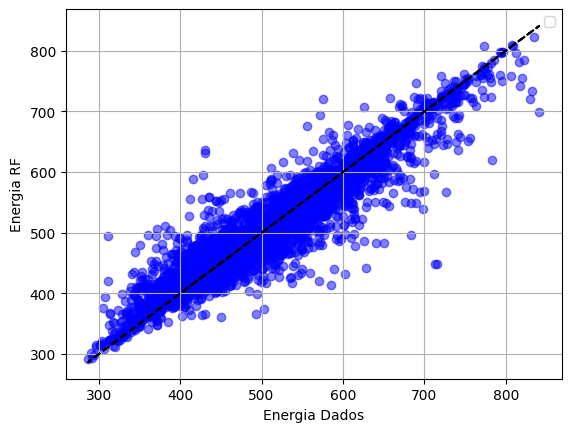

C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
PermutationExplainer explainer:   1%|          | 2/300 [00:00<?, ?it/s]C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted wit

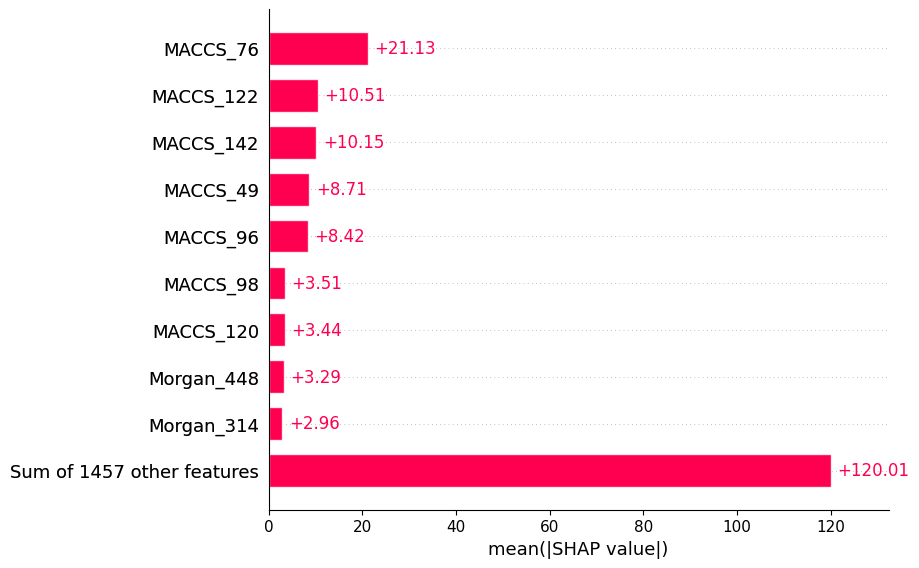

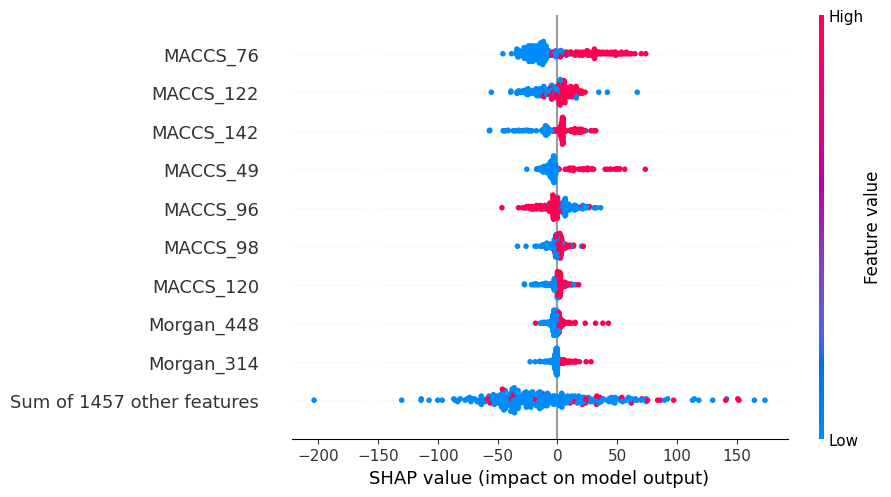

Start of training Thu Nov 14 12:59:13 2024
End of training Thu Nov 14 13:59:10 2024


In [40]:
##################### Wl - ExtraTreesRegressor ####################
hiperParams = {'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 400, 'random_state': 42}
ExtraTreesRegressorToAll(normalized_data, Wl_list,hiperParams, 'blue')

Cross Validation:::


Média do MSE: 0.05226792362346644
Média do MAE: 0.17092927495126828
Média do R²: 0.4637782990743214
Média do RMSE: 0.22858122534334516
Média do MAPE: 1407.6685975243606
Fold 1: MSE = 0.04950399734462108, MAE = 0.16854701699666746, R² = 0.4893190816755545, RMSE = 0.22249493779549476, MAPE = 1388.5061630215
Fold 2: MSE = 0.05355911611232951, MAE = 0.17596467671214083, R² = 0.4544392256614149, RMSE = 0.23142842546309975, MAPE = 1511.926203116016
Fold 3: MSE = 0.0537406574134487, MAE = 0.1682761311449965, R² = 0.4475765898859948, RMSE = 0.23182031277144094, MAPE = 1322.573426435566


 Test model evaluation results:
MAE: 0.15976924322482855
MSE: 0.04709171631875848
RMSE: 0.2170062587087259
R2: 0.5100952573451618
MAPE: 1237.7752231245888
Training model evaluation results:
MAE: 0.11465208962815765
MSE: 0.02597583867234802
RMSE: 0.1611702164556095
R2: 0.7335754193128885
MAPE: 894.3043322936303


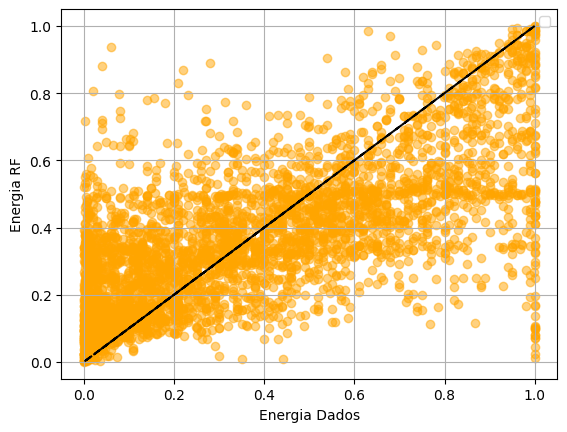

C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
PermutationExplainer explainer:   1%|          | 2/300 [00:00<?, ?it/s]C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted wit

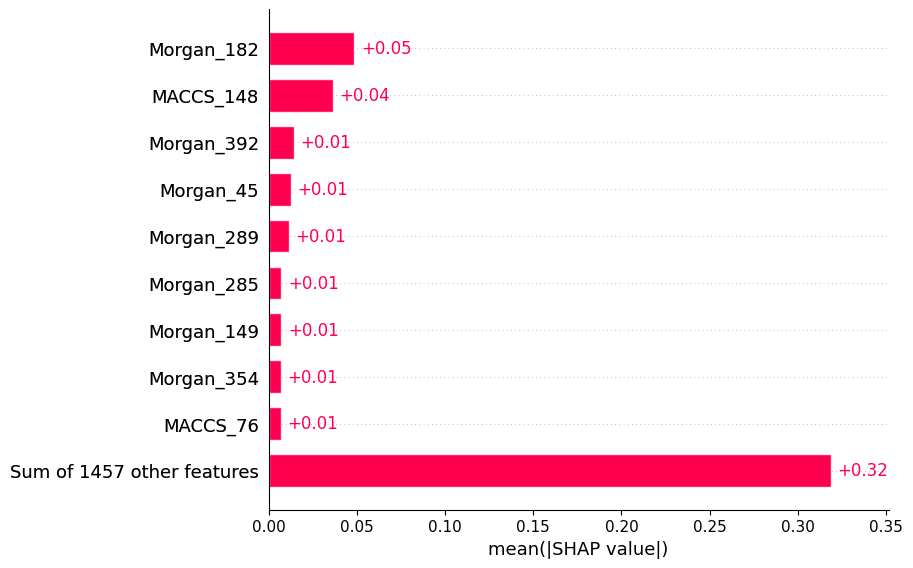

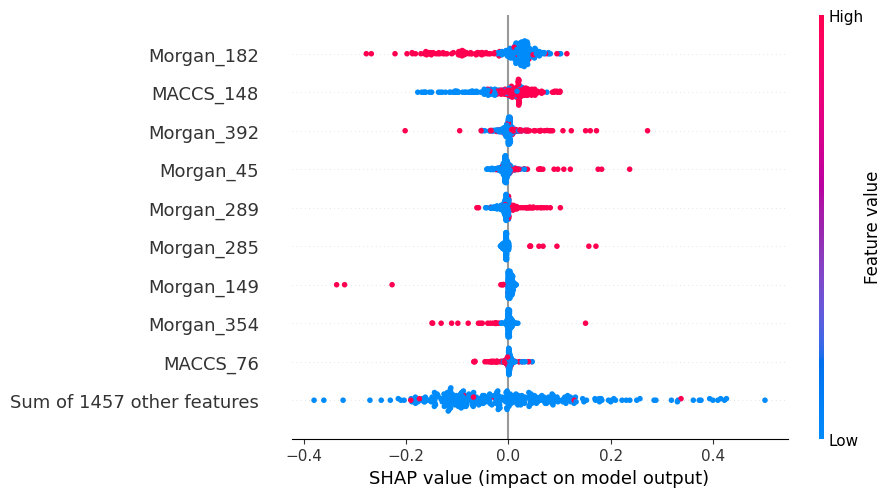

Start of training Thu Nov 14 13:59:10 2024
End of training Thu Nov 14 14:46:20 2024


In [41]:
##################### QY - ExtraTreesRegressor - ####################
hiperParams = {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 400, 'random_state': 60}
ExtraTreesRegressorToAll(normalized_data2, QY_list, hiperParams, 'orange')

## Below we have the test with random forest

In [21]:
##################### func - RandomForestRegressor ####################

def RandomForestRegressorToAll(pa, list, hiperParams, color):
    X_train, X_test, y_train, y_test = train_test_split(pa, list, test_size=0.3, random_state=200)
    inicio = time.ctime()

    regr = RandomForestRegressor(**hiperParams)

    try:
        ###------- CrossValidation -------###
        funcCrossValidation(regr, X_train, y_train)

        ###------- Testing Overfiting and final result -------###
        regr.fit(X_train, y_train)
        joblib.dump(regr, f'{color}_Random.pkl')

        y_pred = regr.predict(X_test)
        resultados = avaliar_modelo(y_test, y_pred)

        
        # print test results
        print("\n\n Test model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")

        y_pred2 = regr.predict(X_train)
        resultados = avaliar_modelo(y_train, y_pred2)

        # print training results
        print("Training model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")
        
        ###------- draw graph test -------###
        grafic(y_test, y_pred, color)
        

        ###------- Shap - importances values -------###

        funcImportances(regr, X_test)
    except Exception as e:
        # print error
        print(f"Ocorreu um erro: {e}")

    print('Start of training', inicio)
    print('End of training', time.ctime())

Cross Validation:::


Média do MSE: 1158.5917940729894
Média do MAE: 22.68857856758115
Média do R²: 0.869275926116727
Média do RMSE: 34.03249195189596
Média do MAPE: 4.576076619526219
Fold 1: MSE = 1099.7081221068236, MAE = 22.30758591961507, R² = 0.8747411018237143, RMSE = 33.16184738682125, MAPE = 4.5527228918005225
Fold 2: MSE = 1184.0069651209462, MAE = 23.00465407000367, R² = 0.8696734221842415, RMSE = 34.40940227787961, MAPE = 4.632934175498771
Fold 3: MSE = 1192.0602949911986, MAE = 22.753495713124707, R² = 0.863413254342225, RMSE = 34.526226190987025, MAPE = 4.542572791279366


 Test model evaluation results:
MAE: 18.573436781187958
MSE: 832.2022711579423
RMSE: 28.847916235976946
R2: 0.9043256217092667
MAPE: 3.7691669542020905
Training model evaluation results:
MAE: 9.553777116331034
MSE: 219.1601760385777
RMSE: 14.804059444577279
R2: 0.975285300776503
MAPE: 1.9242806240674024


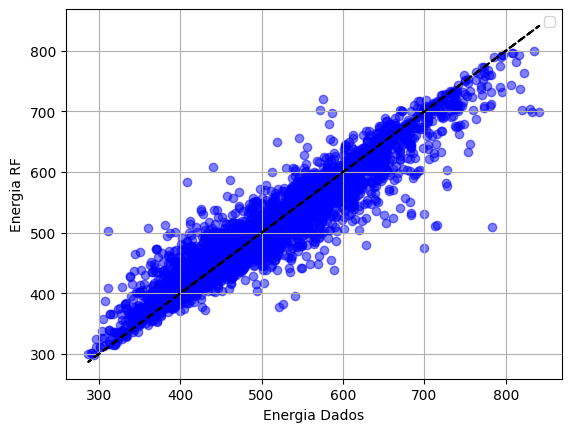

C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
PermutationExplainer expl

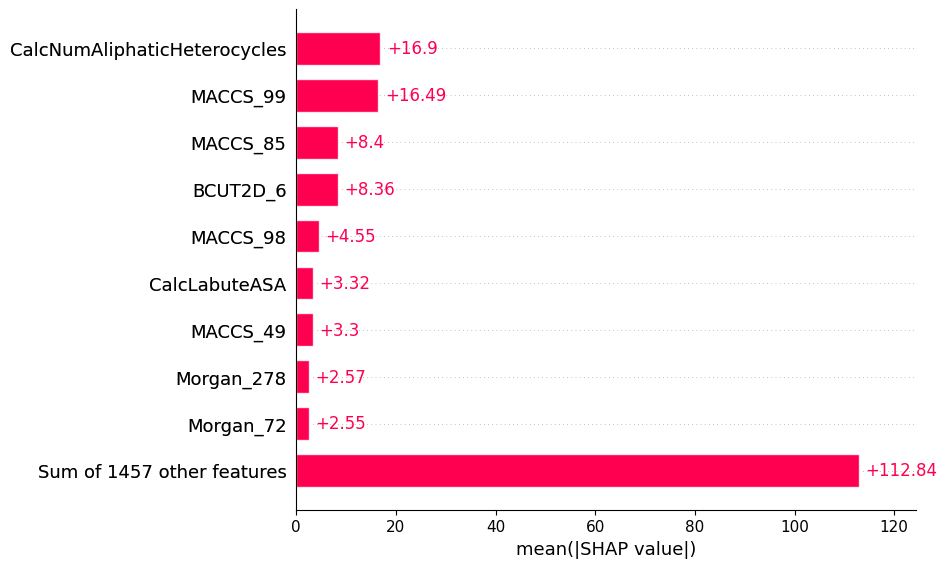

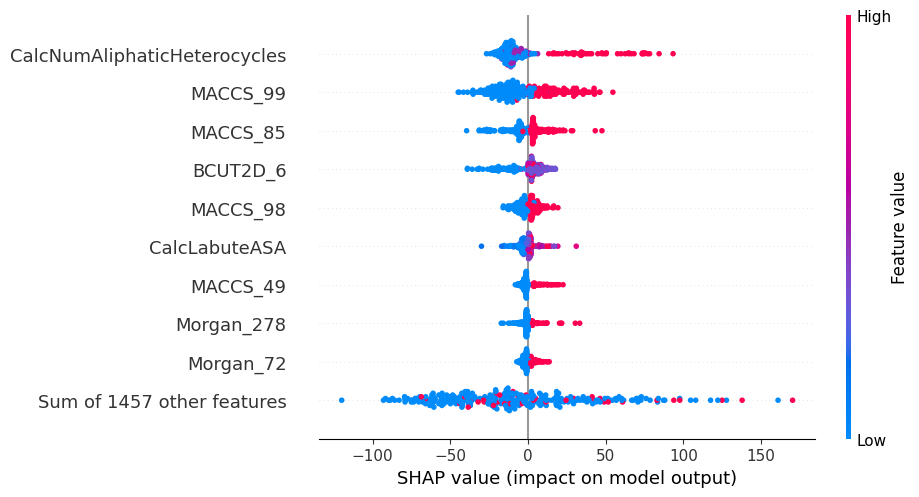

Start of training Thu Nov 14 11:26:19 2024
End of training Thu Nov 14 11:44:40 2024


In [22]:
##################### Wl - Random Forest ####################
X_train, X_test, y_train, y_test = train_test_split(paWl_list, Wl_list, test_size=0.3, random_state=200)
hiperParams = {'max_leaf_nodes': 10000, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 42}
RandomForestRegressorToAll(normalized_data, Wl_list, hiperParams, 'blue')

Cross Validation:::


Média do MSE: 0.044376800054336495
Média do MAE: 0.15748041255057135
Média do R²: 0.5446777138012644
Média do RMSE: 0.21065784047488623
Média do MAPE: 1333.8777896492154
Fold 1: MSE = 0.04425435969857621, MAE = 0.1563990623406091, R² = 0.5434740977905121, RMSE = 0.2103672020505483, MAPE = 1201.012656273308
Fold 2: MSE = 0.044530483958335844, MAE = 0.15931285365490264, R² = 0.5464061569083838, RMSE = 0.21102247263819046, MAPE = 1332.6282389576336
Fold 3: MSE = 0.04434555650609742, MAE = 0.15672932165620237, R² = 0.5441528867048974, RMSE = 0.21058384673591996, MAPE = 1467.9924737167044


 Test model evaluation results:
MAE: 0.13762566018943273
MSE: 0.036032914050207594
RMSE: 0.18982337593196363
R2: 0.6251422359426919
MAPE: 972.8260102867996
Training model evaluation results:
MAE: 0.0699178332777052
MSE: 0.00947496915502428
RMSE: 0.09733945322953216
R2: 0.9028187418318888
MAPE: 585.1782841637845


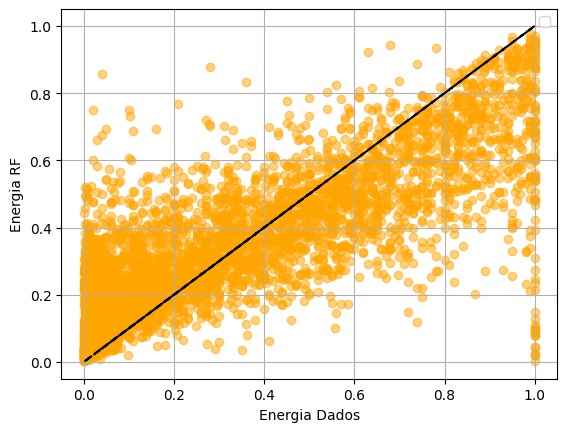

C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Usuário\AppData\

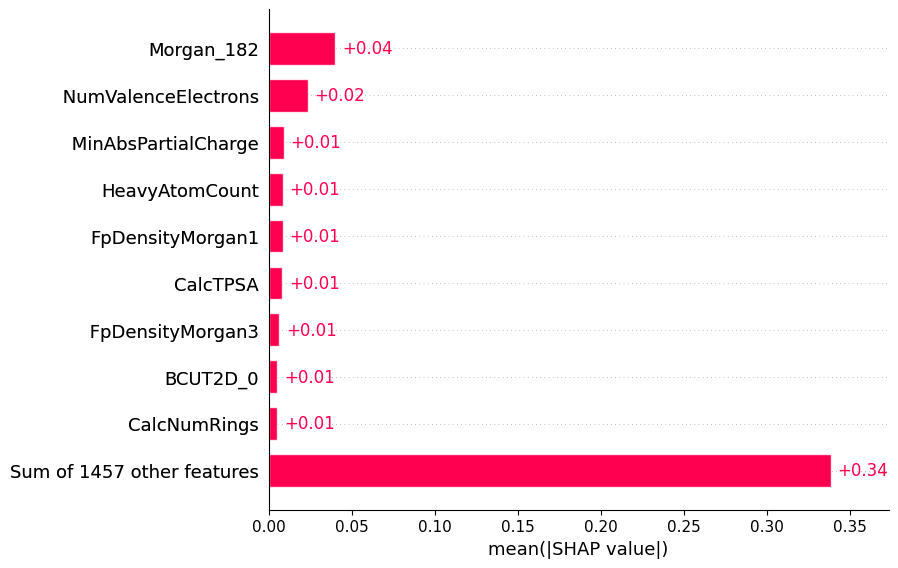

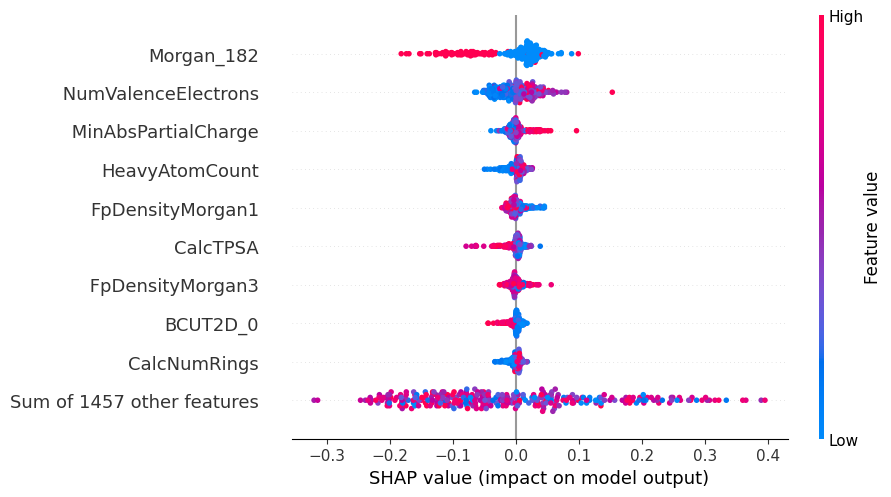

Start of training Thu Nov 14 11:44:40 2024
End of training Thu Nov 14 12:02:02 2024


In [23]:
##################### QY - Random Forest - ####################
hiperParams = {'max_leaf_nodes': 10000, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 42}
RandomForestRegressorToAll(normalized_data2, QY_list, hiperParams, 'orange')

## Below we have the test with XGB

In [29]:
##################### func - XGB ####################

def funcXGB(pa, list, hiperParams, color):
    X_train, X_test, y_train, y_test = train_test_split(pa, list, test_size=0.3, random_state=200)
    inicio = time.ctime()

    regr = regr = xgb.XGBRegressor(**hiperParams)

    try:
        ###------- CrossValidation -------###
        funcCrossValidation(regr, X_train, y_train)

        ###------- Testing Overfiting and final result -------###
        regr.fit(X_train, y_train)
        joblib.dump(regr, f'{color}_XGB_model.pkl')

        y_pred = regr.predict(X_test)
        resultados = avaliar_modelo(y_test, y_pred)

        
        # print test results
        print("\n\n Test model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")

        y_pred2 = regr.predict(X_train)
        resultados = avaliar_modelo(y_train, y_pred2)

        # print training results
        print("Training model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")
        
        ###------- draw graph test -------###
        grafic(y_test, y_pred, color)
        

        ###------- Shap - importances values -------###

        funcImportances(regr, X_test)
    except Exception as e:
        # print error
        print(f"Ocorreu um erro: {e}")

    print('Start of training', inicio)
    print('End of training', time.ctime())

    

Cross Validation:::


Média do MSE: 1081.0890646039816
Média do MAE: 23.11566029616476
Média do R²: 0.8780173063278198
Média do RMSE: 32.876377955561075
Média do MAPE: 4.685097318072107
Fold 1: MSE = 1036.527237847962, MAE = 22.98850637410144, R² = 0.8819375038146973, RMSE = 32.19514307854466, MAPE = 4.713760840139581
Fold 2: MSE = 1101.0734630473928, MAE = 23.133561410628094, R² = 0.8788021206855774, RMSE = 33.182427021653986, MAPE = 4.681812002812472
Fold 3: MSE = 1105.6664929165897, MAE = 23.22491310376474, R² = 0.8733122944831848, RMSE = 33.25156376648457, MAPE = 4.659719111264268


 Test model evaluation results:
MAE: 20.856437379280024
MSE: 865.0192278615006
RMSE: 29.411209221341114
R2: 0.9005528092384338
MAPE: 4.246826580707419
Training model evaluation results:
MAE: 15.890390809238875
MSE: 484.0187412857268
RMSE: 22.00042593418879
R2: 0.9454171657562256
MAPE: 3.2459218794115117


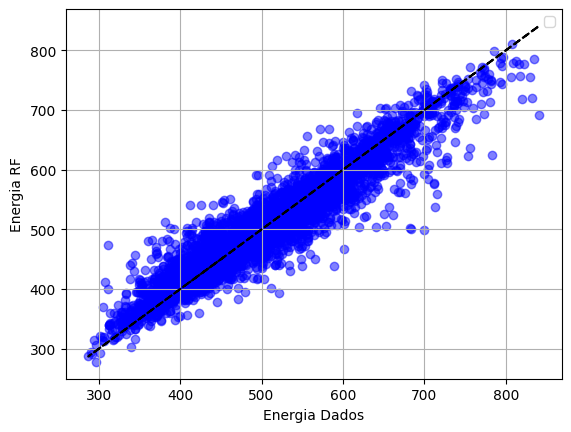

PermutationExplainer explainer: 301it [06:39,  1.36s/it]                         


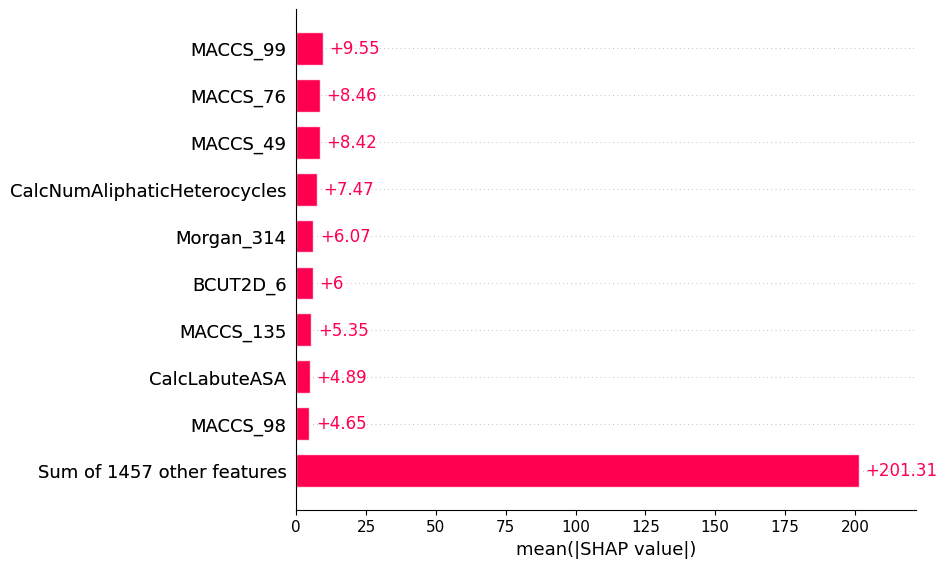

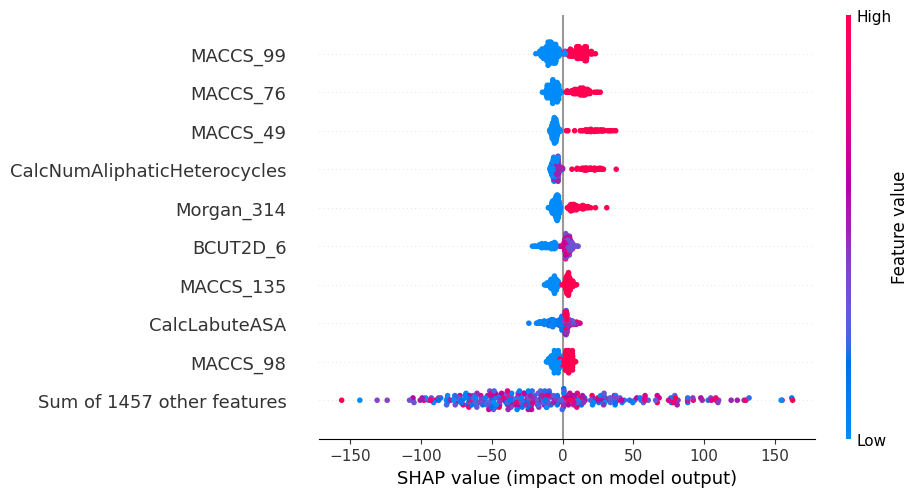

Start of training Thu Nov 14 12:34:36 2024
End of training Thu Nov 14 12:41:26 2024


In [30]:
##################### Wl - XGB ####################
X_train, X_test, y_train, y_test = train_test_split(paWl_list, Wl_list, test_size=0.3, random_state=200)
hiperParams = {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}
funcXGB(normalized_data, Wl_list, hiperParams, 'blue')

Cross Validation:::


Média do MSE: 0.04741034994441268
Média do MAE: 0.16182151782057283
Média do R²: 0.5153329875487245
Média do RMSE: 0.21773701116796187
Média do MAPE: 1355.5269926176495
Fold 1: MSE = 0.04800177009568472, MAE = 0.1641337593780401, R² = 0.5201811790726609, RMSE = 0.2190930626370555, MAPE = 1168.0887089425785
Fold 2: MSE = 0.047031461921720176, MAE = 0.16006067186286127, R² = 0.5041200239070505, RMSE = 0.21686738325926325, MAPE = 1906.2751283849907
Fold 3: MSE = 0.04719781781583311, MAE = 0.16127012222081716, R² = 0.5216977596664621, RMSE = 0.21725058760756694, MAPE = 992.2171405253794


 Test model evaluation results:
MAE: 0.15169060669735193
MSE: 0.04315264565385993
RMSE: 0.20773214882116808
R2: 0.5531280326836006
MAPE: 1015.4159955171663
Training model evaluation results:
MAE: 0.08611003639697443
MSE: 0.013730603815251667
RMSE: 0.11717765919855058
R2: 0.8597147207447768
MAPE: 694.2245404216582


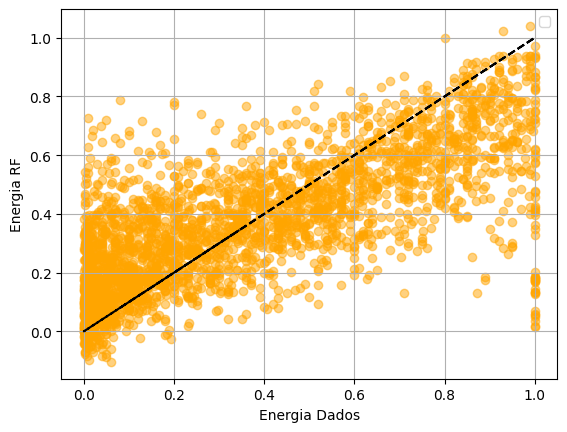

PermutationExplainer explainer: 301it [06:23,  1.31s/it]                         


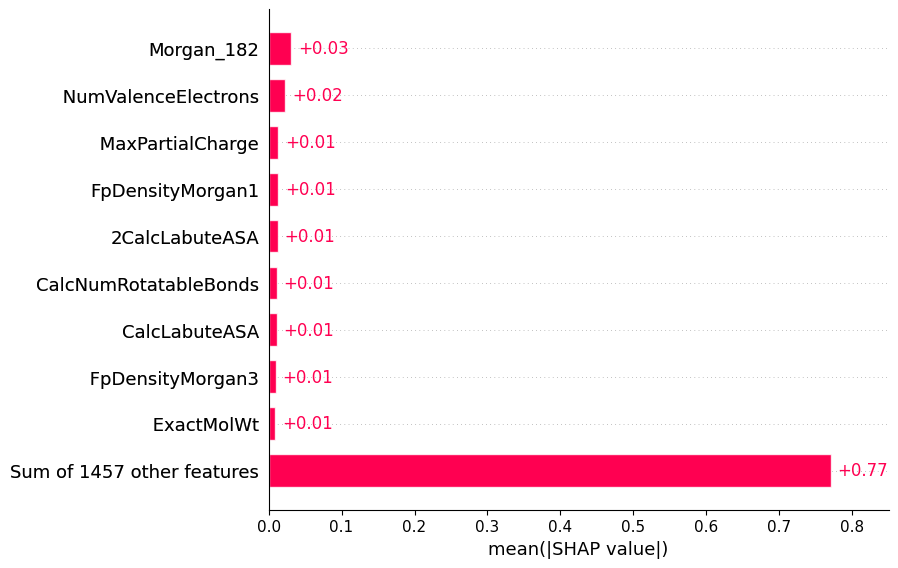

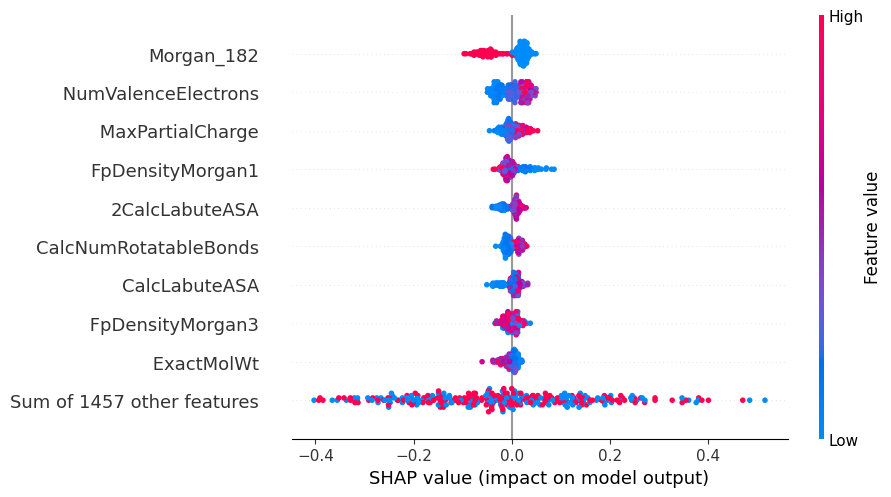

Start of training Thu Nov 14 12:41:26 2024
End of training Thu Nov 14 12:47:57 2024


In [31]:
##################### QY - XGB ####################
X_train, X_test, y_train, y_test = train_test_split(normalized_data2, QY_list, test_size=0.3, random_state=200)
hiperParams = {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.8}
funcXGB(X_train, y_train, hiperParams, 'orange')

Start of training Thu Nov 21 07:49:36 2024
18079


C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │        23,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,617 (92.25 KB)

 Trainable params: 23,617 (92.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4429/4429 ━━━━━━━━━━━━━━━━━━━━ 4s 679us/step - loss: 181.3710 - mean_squared_error: 71046.4062 - val_loss: 53.8480 - val_mean_squared_error: 7217.1543
Epoch 2/20
4429/4429 ━━━━━━━━━━━━━━━━━━━━ 3s 639us/step - loss: 47.6184 - mean_squared_error: 5394.0088 - val_loss: 46.5498 - val_mean_squared_error: 5286.5171
Epoch 3/20
4429/4429 ━━━━━━━━━━━━━━━━━━━━ 3s 628us/step - loss: 39.3968 - mean_squared_error: 3402.7246 - val_loss: 42.7455 - val_mean_squared_error: 4378.5366
Epoch 4/20
4429/4429 ━━━━━━━━━━━━━━━━━━━━ 3s 624us/step - loss: 37.2062 - mean_squared_error: 3129.4292 - val_loss: 41.3911 - val_mean_squared_error: 4021.7280
Epoch 5/20
4429/4429 ━━━━━━━━━━━━━━━━━━━━ 3s 625us/step - loss: 34.0043 - mean_squared_error: 2680.9077 - val_loss: 40.0635 - val_mean_squared_error: 3704.7786
Epoch 6/20
4429/4429 ━━━━━━━━━━━━━━━━━━━━ 3s 623us/step - loss: 33.0584 - mean_squared_error: 2330.3171 - val_loss: 38.7292 - val_mean_squared_error: 3480.1863
Epoch 7/20
4429/4429 ━━━━━━━━━━━━━━━━━

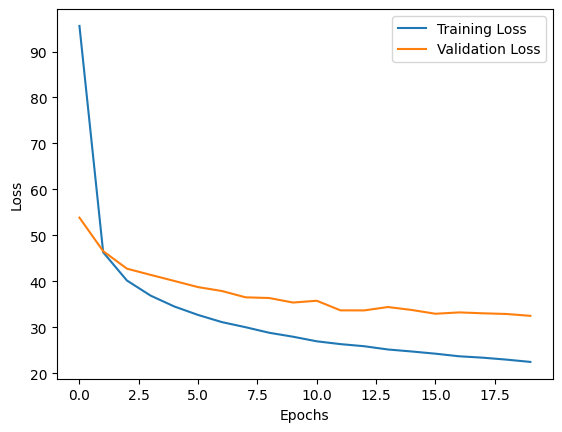

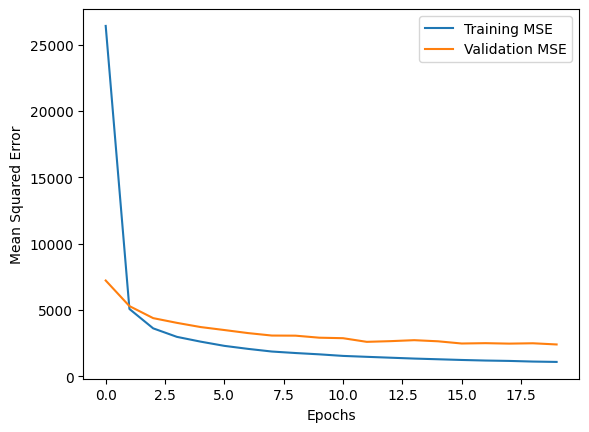

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
5424
Resultados da avaliação do modelo de teste:
MAE: 30.35748525073746
MSE: 2093.761983775811
RMSE: 45.75764399284355
R2: 0.7592900395393372
MAPE: 20.769399003338528
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
Resultados da avaliação do modelo de treinamento:
MAE: 21.228901532143656
MSE: 985.6696725526774
RMSE: 31.39537661109797
R2: 0.8898062109947205
MAPE: 20.766156445049862
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
Resultados da avaliação do modelo de validação:
MAE: 32.47930897603953
MSE: 2391.6527537191837
RMSE: 48.90452692460263
R2: 0.724668025970459
MAPE: 20.66090837581175
Start of training Thu Nov 21 07:50:44 2024
End of training Thu Nov 21 07:50:46 2024


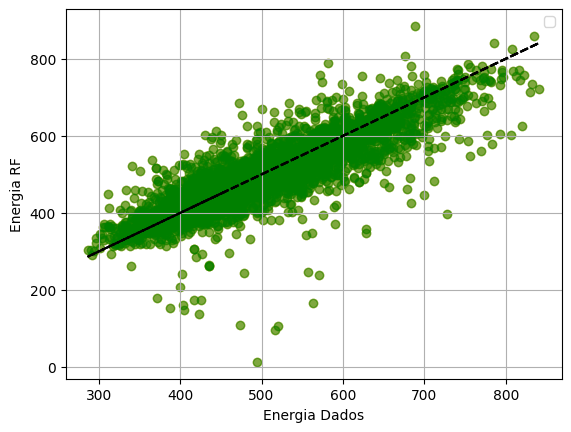

In [ ]:
##################### WL ####################
print('Start of training', time.ctime())
inicio = time.ctime()

from math import sqrt, ceil
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

rad = 2

n_est = 1000
sizeleaf = 5
m_fac = 733

X_temp, X_test, y_temp, y_test = train_test_split(normalized_data, Wl_list, test_size=0.3, random_state=200)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=200) 

len_train = len(Wl_list)
print(len_train)

m_node = ceil(len_train/sizeleaf)

modelo2 = Sequential()
modelo2.add(Dense(units=16, input_dim=len(normalized_data[0]), activation='relu'))
modelo2.add(Dense(units=8, activation='relu'))
modelo2.add(Dense(units=1, activation='linear'))
modelo2.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])
modelo2.summary()

history2 = modelo2.fit(X_train, y_train, epochs=20, batch_size=2, validation_data=(X_val, y_val))

print('Start of training', inicio)
print('End of training', time.ctime())


plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history2.history['mean_squared_error'], label='Training MSE')
plt.plot(history2.history['val_mean_squared_error'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


inicio = time.ctime()
y_pred = modelo2.predict(X_test)
resultados = avaliar_modelo(y_test, np.round(y_pred))
print(len(y_pred))



print("Resultados da avaliação do modelo de teste:")
for metrica, valor in resultados.items():
    print(f"{metrica}: {valor}")


y_pred2 = modelo2.predict(X_train)
resultados = avaliar_modelo(y_train, y_pred2)



print("Resultados da avaliação do modelo de treinamento:")
for metrica, valor in resultados.items():
    print(f"{metrica}: {valor}")

y_pred3 = modelo2.predict(X_val)
resultados = avaliar_modelo(y_val, y_pred3)



print("Resultados da avaliação do modelo de validação:")
for metrica, valor in resultados.items():
    print(f"{metrica}: {valor}")

print('Start of training', inicio)
print('End of training', time.ctime())


############ Gráfico Energy


plt.plot(y_test, y_test, linestyle='--', color='black', label='y = x')
plt.scatter(y_test, y_pred, alpha=0.5, color='orange', label='Pontos de Teste vs. Previsões')

modelo2.save('WL-RNA.keras')
grafic(y_test, y_pred, 'green')


Start of training Thu Nov 14 12:16:10 2024
13685


C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │        23,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,617 (92.25 KB)

 Trainable params: 23,617 (92.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 3s 725us/step - loss: 0.6289 - mean_squared_error: 5.3479 - val_loss: 0.2802 - val_mean_squared_error: 0.3068
Epoch 2/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 2s 699us/step - loss: 0.2505 - mean_squared_error: 0.1995 - val_loss: 0.2276 - val_mean_squared_error: 0.0876
Epoch 3/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 2s 703us/step - loss: 0.2074 - mean_squared_error: 0.0750 - val_loss: 0.2083 - val_mean_squared_error: 0.0779
Epoch 4/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 2s 701us/step - loss: 0.1881 - mean_squared_error: 0.0651 - val_loss: 0.2064 - val_mean_squared_error: 0.0896
Epoch 5/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 2s 717us/step - loss: 0.1725 - mean_squared_error: 0.0569 - val_loss: 0.1934 - val_mean_squared_error: 0.0699
Epoch 6/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 2s 708us/step - loss: 0.1599 - mean_squared_error: 0.0494 - val_loss: 0.1884 - val_mean_squared_error: 0.0698
Epoch 7/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 2s 699us/step - loss: 0.1494 - mean_squared_er

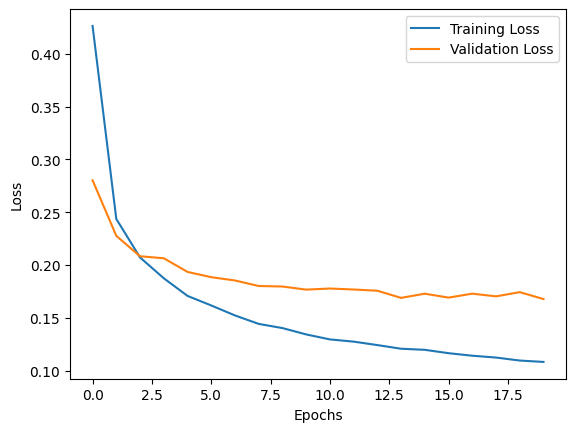

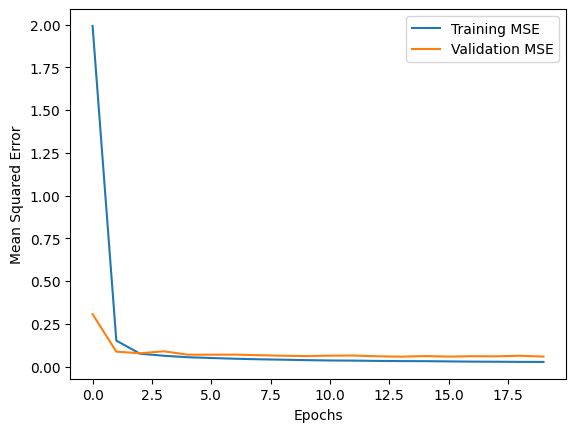

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
4106
Resultados da avaliação do modelo de teste:
MAE: 0.2698360277642475
MSE: 0.138870279337774
RMSE: 0.37265302808077916
R2: -0.44469587816397693
MAPE: 2111.4335090243967
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
Resultados da avaliação do modelo de treinamento:
MAE: 0.10386836058719585
MSE: 0.026333403872004967
RMSE: 0.16227570327071444
R2: 0.7309521878548877
MAPE: 2959.7566484791555
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
Resultados da avaliação do modelo de validação:
MAE: 0.16772664039875618
MSE: 0.05880184702520408
RMSE: 0.24249092153151647
R2: 0.39107100703012176
MAPE: 2426.124918547266
Start of training Thu Nov 14 12:16:58 2024
End of training Thu Nov 14 12:16:59 2024


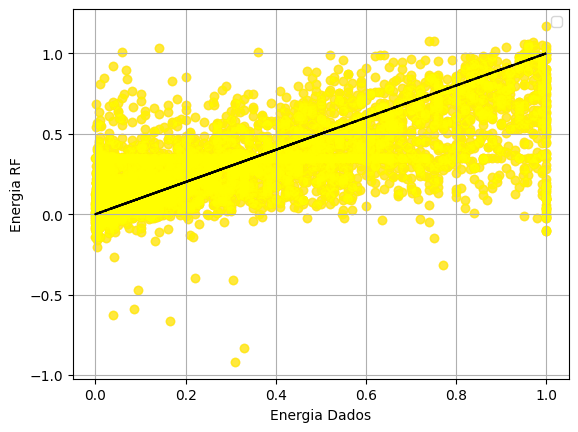

In [ ]:
##################### QY ####################
print('Start of training', time.ctime())
inicio = time.ctime()


from sklearn.model_selection import train_test_split
from math import sqrt, ceil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split




rad = 2

n_est = 1000
sizeleaf = 5
m_fac = 733

X_temp, X_test, y_temp, y_test = train_test_split(normalized_data2, QY_list, test_size=0.3, random_state=200)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=200) 

len_train = len(QY_list)
print(len_train)

m_node = ceil(len_train/sizeleaf)


modelo3 = Sequential()
modelo3.add(Dense(units=16, input_dim=len(normalized_data2[0]), activation='relu'))
modelo3.add(Dense(units=8, activation='relu'))
modelo3.add(Dense(units=1, activation='linear'))
modelo3.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])
modelo3.summary()

history2 = modelo3.fit(X_train, y_train, epochs=20, batch_size=2, validation_data=(X_val, y_val))


print('Start of training', inicio)
print('End of training', time.ctime())



import matplotlib.pyplot as plt


plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history2.history['mean_squared_error'], label='Training MSE')
plt.plot(history2.history['val_mean_squared_error'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


inicio = time.ctime()
y_pred = modelo3.predict(X_test)
resultados = avaliar_modelo(y_test, np.round(y_pred))
print(len(y_pred))



print("Resultados da avaliação do modelo de teste:")
for metrica, valor in resultados.items():
    print(f"{metrica}: {valor}")


y_pred2 = modelo3.predict(X_train)
resultados = avaliar_modelo(y_train, y_pred2)



print("Resultados da avaliação do modelo de treinamento:")
for metrica, valor in resultados.items():
    print(f"{metrica}: {valor}")

y_pred3 = modelo3.predict(X_val)
resultados = avaliar_modelo(y_val, y_pred3)



print("Resultados da avaliação do modelo de validação:")
for metrica, valor in resultados.items():
    print(f"{metrica}: {valor}")

print('Start of training', inicio)
print('End of training', time.ctime())


############ Gráfico Energy

plt.plot(y_test, y_test, linestyle='--', color='black', label='y = x')
plt.scatter(y_test, y_pred, alpha=0.5, color='orange', label='Pontos de Teste vs. Previsões')

modelo3.save('QY-RNA.keras')
grafic(y_test, y_pred, 'yellow')
